# Exploring SAT Scores vs. Income, Crime, and Race with Linear Regression

To explore different factors affecting standardizd test scores, test scores and other data was collected from 372 schools in the New York City public school system. Variables analyzed included average SAT scores (including the three subtests), student demographics like race, ethnicity, and gender, class size, and crime rates. As expected from most current research, income level proved to be the strongest predictor for SAT test scores for all SAT sections. However, after adjusting for income, factors such as race and local crime rates still showed statistically significant negative correlations with test scores, suggesting that other background factors could still be playing a role in the academic success of some students that can't be explained by income alone.

All data for this analysis comes from the New York City Open Data initiative, a dataset released by the NYC government containing hundreds of datasets on education in the NYC public school system. The dependent variable came from the dataset "2012 SAT Results", which was sourced directly from College Board and contains school-wide test scores for each subject category as well as the number of SAT test takers as a percentage of total students. The "2012 SAT Results" were reported directly from College Board and includes the average scores per school for all college-bound seniors in New York City public schools. Information is collected from the SAT Questionaire filled out by students prior to taking the test. Students who do not identify as graduating next year are not counted in the dataset. Students are then linked with their high school based on a mandatory but self-reported part of test registration. The self-reported nature of this collection process might be the cause of some bias, although it would be generally disadvantageous for a student to report the incorrect school.

This dataset can be found here:
https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4

We will import the dataset and create a "SAT Total Score" column. Note that we are also removing all rows with "s", which represents schools with too low sample size.

In [95]:
sat <- read.csv("2012_SAT_Results.csv")
sat <- sat[sat$Num.of.SAT.Test.Takers != 's',]
sat[,3:6] <- as.numeric((as.matrix(sat[,3:6])))
sat$SAT.Total <- sat$SAT.Critical.Reading.Avg..Score + sat$SAT.Math.Avg..Score + sat$SAT.Writing.Avg..Score
summary(sat)

      DBN     
 01M292 :  1  
 01M448 :  1  
 01M450 :  1  
 01M458 :  1  
 01M509 :  1  
 01M515 :  1  
 (Other):415  
                                                                         SCHOOL.NAME 
 47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECONDARY SCHOOL                    :  1  
 ABRAHAM LINCOLN HIGH SCHOOL                                                   :  1  
 ACADEMY FOR CAREERS IN TELEVISION AND FILM                                    :  1  
 ACADEMY FOR COLLEGE PREPARATION AND CAREER EXPLORATION: A COLLEGE BOARD SCHOOL:  1  
 ACADEMY FOR CONSERVATION AND THE ENVIRONMENT                                  :  1  
 ACADEMY FOR ENVIRONMENTAL LEADERSHIP                                          :  1  
 (Other)                                                                       :415  
 Num.of.SAT.Test.Takers SAT.Critical.Reading.Avg..Score SAT.Math.Avg..Score
 Min.   :   6.0         Min.   :279.0                   Min.   :312.0      
 1st Qu.:  41.0         1st Qu.:368.0   

# Merging the 4 Datasets

We have three tables of independent variables that we want to merge. First is the "2006-2012 School Demographics and Accountability Snapshot". This contains all demographic reports and enrollment information mandatorily reported yearly by each school, including information on race, ethnicity, gender, enrollment by grade, and percentages of students on free or reduced lunch (FRL). All data will need to be filtered to only include the appropriate grade. The most significant variables ended up being the racial and ethnic backgrounds as well as FRL percentage. FRL serves as the closest possible proxy for income. Inclusion in free or reduced lunch programs are determined directly by using income compared to local poverty lines. Some information is lost from the use of binary categorization. One, we cannot see the distribution of incomes beyond the cut-off point, which may produce misleading numbers for some schools that, for example, could have a large split of low-income and high-income students, common for some charter or specialty school programs which may bus low-income students from different parts of the city. There may also be misleading results if there is clustering close above or close below the poverty cut-off line. Nonetheless, this is likely the closest possible proxy to income available in public datasets, and also has the advantage of FRL programs being standardized by family size. 

This dataset can be found here: https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j

We are going to import the data. We will also first filter the dataset by school year to obtain only seniors.

In [96]:
demo <- read.csv("2006_-_2012_School_Demographics_and_Accountability_Snapshot.csv")
demo <- demo[demo$schoolyear==20112012,]
head(demo)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,⋯,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
7,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,,89.4,189,13,31,35,28,⋯,63,33.3,109,57.7,4,2.1,97,51.3,92,48.7
14,01M019,P.S. 019 ASHER LEVY,20112012,,61.5,328,32,46,52,54,⋯,81,24.7,158,48.2,28,8.5,147,44.8,181,55.2
21,01M020,PS 020 ANNA SILVER,20112012,,92.5,626,52,102,121,87,⋯,55,8.8,357,57.0,16,2.6,330,52.7,296,47.3
28,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,,99.7,401,14,34,38,36,⋯,90,22.4,275,68.6,8,2.0,204,50.9,197,49.1
36,01M063,PS 063 WILLIAM MCKINLEY,20112012,,78.9,176,18,20,30,21,⋯,41,23.3,110,62.5,15,8.5,97,55.1,79,44.9
43,01M064,PS 064 ROBERT SIMON,20112012,,76.9,324,27,54,50,42,⋯,76,23.5,193,59.6,24,7.4,184,56.8,140,43.2


Since each row on both of the two tables has an identical "DBN" column, we can use these to link all the information from both tables into one table using a left outer join. 

In [97]:
df <- merge(x = sat, y = demo, by = "DBN", all.x = TRUE)
keep <- c("DBN", "SCHOOL.NAME",  "Num.of.SAT.Test.Takers", "SAT.Critical.Reading.Avg..Score", "SAT.Math.Avg..Score",
         "SAT.Writing.Avg..Score", "SAT.Total", "frl_percent", "total_enrollment", "grade12", "asian_per", "black_per", "hispanic_per",
         "white_per", "male_per")
df <- df[keep]
df$Percent.SAT.Taken <- df$Num.of.SAT.Test.Takers / df$grade12
head(df)

DBN,SCHOOL.NAME,Num.of.SAT.Test.Takers,SAT.Critical.Reading.Avg..Score,SAT.Math.Avg..Score,SAT.Writing.Avg..Score,SAT.Total,frl_percent,total_enrollment,grade12,asian_per,black_per,hispanic_per,white_per,male_per,Percent.SAT.Taken
01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122,88.6,422,50,14.0,29.1,53.8,1.7,61.4,0.5800000
01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,1172,71.8,394,95,29.2,22.6,45.9,2.3,57.4,0.9578947
01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,1149,71.8,598,86,9.7,23.9,55.4,10.4,54.7,0.8139535
01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,1174,72.8,224,NA,2.2,34.4,59.4,3.6,43.3,NA
01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,1207,80.7,367,73,9.3,31.6,56.9,1.6,46.3,0.6027397
01M515,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,112,332,557,316,1205,77.0,562,92,84.7,5.2,8.9,0.9,53.7,1.2173913


The second dataset used was class size, which was sourced from the "2011-2012 Class Size" dataset and measures the number of students in each class. This data was then combined with the enrollment data from the previous dataset to obtain the average number of students per class.

In [98]:
classSize <- read.csv("2010-2011_Class_Size_-_School-level_detail.csv")
classSize <- classSize[classSize$GRADE == "09-12",]
keep <- c("SCHOOL.CODE", "AVERAGE.CLASS.SIZE")
classSize <-na.omit(classSize[keep])

classSizeAgg <- aggregate(classSize$AVERAGE.CLASS.SIZE, by=list(Code = classSize$SCHOOL.CODE), FUN=mean)
names(classSizeAgg) <- c("DBN", "Average.Class.Size")

Now we just do the same join to the full table as we did with the first two tables. The only difference is it uses a shorter part of the DBN code.

In [99]:
df$DBN <- substring(df$DBN, 3)
df <- merge(x = df, y = classSizeAgg, by = "DBN", all.x = TRUE)

The last dataset used was for crime data and came from the "2010-2016 School Safety Report" was a dataset collected by the New York Police Department but contained counts of all criminal incidents by school as required by NY law since 1998. The school safety dataset contains the raw number of crimes for each category, as well as the average number of crimes from each category based on the building's size and population.

The data for the school safety report is structured the most annoyingly. Instead of providing crime data for each school, crime data is instead provided per each building, since there may be multiple schools per building as well as multiple sites for one school. Schools from buildings in which they are the only school has the crime data on the same row as their DBN as normal. But buildings with multiple schools are called "consolidated locations". Schools from consolidated locations get null values on their row, and instead each consolidated locations gets its own row with their crime data. 

So essentially, we need to reformat this table so that we have crime data for each DBN. To do this, we need to extract the crime data from the consolidated locations, and then join them back into their DBNs using the Location Codes as the intersection.

In [100]:
safety <- read.csv("2010_-_2016_School_Safety_Report.csv")
safety <- safety[safety$School.Year=="2015-16",]
keepTheseColumns <- c("DBN", "Building.Code", "Location.Code", "Major.N", "NoCrim.N", "Prop.N", "Vio.N", 
                      "AvgOfMajor.N", "AvgOfNoCrim.N", "AvgOfProp.N", "AvgOfVio.N")
safety <- na.omit ( safety[keepTheseColumns] )

First step: grab the schools that are part of consolidated locations, as identified as having their crime stats listed as null:

In [101]:
conSchools <- safety[safety$Major.N == "N/A",][,1:3]
head(conSchools)

,DBN,Building.Code,Location.Code
5,75K141,K002,K141
6,84K704,K002,K704
7,17K002,K002,K002
8,75XHOS,X953,X402
15,75M401,X953,M401
16,75KHOS,X953,K403


Next step, grab the crime stats from the consolidated locations, as identified by a blank cell in the DBN or Location.Code columns, along with their building codes so that we can link them to the schools:

In [102]:
conLocation <- safety[safety$DBN == "",]
keep <- c("Building.Code", "Major.N", "NoCrim.N", "Prop.N", "Vio.N", "AvgOfMajor.N", "AvgOfNoCrim.N", 
          "AvgOfProp.N", "AvgOfVio.N")
conLocation <- na.omit ( conLocation[keep] )
head(conLocation)

,Building.Code,Major.N,NoCrim.N,Prop.N,Vio.N,AvgOfMajor.N,AvgOfNoCrim.N,AvgOfProp.N,AvgOfVio.N
4,K002,0,1,0,1,0.38,2.38,0.98,0.82
19,X884,3,16,2,8,0.38,2.38,0.98,0.82
30,X790,5,42,6,6,0.42,3.44,1.02,0.87
35,X660,0,14,1,4,0.57,3.64,1.39,1.05
42,X655,3,1,6,3,0.57,3.64,1.39,1.05
46,X650,1,7,5,5,0.38,2.38,0.98,0.82


Finally, perform a left join using Building.Code as the keys to retrieve the crime stats for all the schools: 

In [103]:
conSchoolWithStats <- merge(x = conSchools, y = conLocation, by = "Building.Code", all.x = TRUE)
head(conSchoolWithStats)

Building.Code,DBN,Location.Code,Major.N,NoCrim.N,Prop.N,Vio.N,AvgOfMajor.N,AvgOfNoCrim.N,AvgOfProp.N,AvgOfVio.N
K002,84K704,K704,0,1,0,1,0.38,2.38,0.98,0.82
K002,17K002,K002,0,1,0,1,0.38,2.38,0.98,0.82
K002,75K141,K141,0,1,0,1,0.38,2.38,0.98,0.82
K009,84K780,K780,0,1,1,0,0.38,2.38,0.98,0.82
K009,13K009,K009,0,1,1,0,0.38,2.38,0.98,0.82
K012,17K484,K484,1,1,2,2,0.24,1.71,0.51,0.32


Now we just need to combine this table with the rest of the schools that aren't part of consolidated locations. We also will exclude all the rows with the consolidated location stats themselves since they do not represent schools. 

In [104]:
restOfSchools <- safety[safety$Major.N != "N/A" & safety$DBN != "",]
safetyCleaned <- rbind(conSchoolWithStats, restOfSchools)
safetyCleaned$DBN <- substring(safetyCleaned$DBN, 3)
safetyCleaned[,4:11] <- as.numeric((as.matrix(safetyCleaned[,4:11])))

In [105]:
safetyCleaned$All.N <- safetyCleaned$Major.N + safetyCleaned$NoCrim.N + safetyCleaned$Prop.N + safetyCleaned$Vio.N
safetyCleaned$Major.N.Odds <- safetyCleaned$Major.N / safetyCleaned$AvgOfMajor.N
safetyCleaned$NoCrim.N.Odds <- safetyCleaned$NoCrim.N / safetyCleaned$AvgOfNoCrim.N
safetyCleaned$Prop.N.Odds <- safetyCleaned$Prop.N / safetyCleaned$AvgOfProp.N
safetyCleaned$Vio.N.Odds <- safetyCleaned$Vio.N / safetyCleaned$AvgOfVio.N
safetyCleaned$All.N.Odds <- safetyCleaned$Major.N.Odds + safetyCleaned$NoCrim.N.Odds + safetyCleaned$Prop.N.Odds + safetyCleaned$Vio.N.Odds
keep <- c("DBN", "Major.N", "NoCrim.N", "Prop.N", "Vio.N", "All.N", "Major.N.Odds", "NoCrim.N.Odds", 
          "Prop.N.Odds", "Vio.N.Odds", "All.N.Odds")
safetyCleaned <- safetyCleaned[keep]

In [106]:
df <- merge(x = df, y = safetyCleaned, by = "DBN", all.x = TRUE)
df <- na.omit(df)
head(df)

,DBN,SCHOOL.NAME,Num.of.SAT.Test.Takers,SAT.Critical.Reading.Avg..Score,SAT.Math.Avg..Score,SAT.Writing.Avg..Score,SAT.Total,frl_percent,total_enrollment,grade12,⋯,Major.N,NoCrim.N,Prop.N,Vio.N,All.N,Major.N.Odds,NoCrim.N.Odds,Prop.N.Odds,Vio.N.Odds,All.N.Odds
1,K071,JUAN MOREL CAMPOS SECONDARY SCHOOL,102,365,361,359,1085,76.6,865,131,⋯,1,5,3,3,12,3.571429,2.8735632,4.000000,5.660377,16.105369
2,K265,DR. SUSAN S. MCKINNEY SECONDARY SCHOOL OF THE ARTS,29,352,349,373,1074,71.1,443,39,⋯,0,3,2,3,8,0.000000,1.7964072,3.174603,6.818182,11.789192
4,K337,INTERNATIONAL HIGH SCHOOL AT LAFAYETTE,54,326,386,314,1026,73.8,343,78,⋯,2,7,6,2,17,2.222222,0.9655172,2.352941,1.379310,6.919991
5,K344,RACHEL CARSON HIGH SCHOOL FOR COASTAL STUDIES,54,402,427,408,1237,70.4,481,82,⋯,3,8,4,3,18,5.263158,2.1978022,2.877698,2.857143,13.195801
6,K348,HIGH SCHOOL OF SPORTS MANAGEMENT,39,388,398,378,1164,69.2,370,64,⋯,2,7,6,2,17,2.222222,0.9655172,2.352941,1.379310,6.919991
7,K350,URBAN ASSEMBLY HIGH SCHOOL OF MUSIC AND ART,52,360,364,356,1080,74.1,431,91,⋯,0,14,0,1,15,0.000000,3.8461538,0.000000,0.952381,4.798535


In [107]:
summary(df)

     DBN           
 Length:372        
 Class :character  
 Mode  :character  
                   
                   
                   
                   
                                                                         SCHOOL.NAME 
 47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECONDARY SCHOOL                    :  1  
 ABRAHAM LINCOLN HIGH SCHOOL                                                   :  1  
 ACADEMY FOR CAREERS IN TELEVISION AND FILM                                    :  1  
 ACADEMY FOR COLLEGE PREPARATION AND CAREER EXPLORATION: A COLLEGE BOARD SCHOOL:  1  
 ACADEMY FOR CONSERVATION AND THE ENVIRONMENT                                  :  1  
 ACADEMY FOR ENVIRONMENTAL LEADERSHIP                                          :  1  
 (Other)                                                                       :366  
 Num.of.SAT.Test.Takers SAT.Critical.Reading.Avg..Score SAT.Math.Avg..Score
 Min.   :   6.0         Min.   :279.0                   Min.   :312.0      


# Pre-Analysis

Let's look at a correlation table to look at some clues to see what might be the best predictor for SAT scores. Data-wide correlation table is:

In [108]:
cor(df[3:length(df)])

,Num.of.SAT.Test.Takers,SAT.Critical.Reading.Avg..Score,SAT.Math.Avg..Score,SAT.Writing.Avg..Score,SAT.Total,frl_percent,total_enrollment,grade12,asian_per,black_per,⋯,Major.N,NoCrim.N,Prop.N,Vio.N,All.N,Major.N.Odds,NoCrim.N.Odds,Prop.N.Odds,Vio.N.Odds,All.N.Odds
Num.of.SAT.Test.Takers,1.0000000000,0.44153792,0.53313344,0.45353505,0.49212167,-0.41780059,0.943468857,0.959107784,0.50005048,-0.28739571,⋯,-0.054547961,-0.027171546,0.02602064,-0.029699945,-0.025062711,-0.14270246,-0.20953503,-0.16915341,-0.15885614,-0.212001111
SAT.Critical.Reading.Avg..Score,0.4415379186,1.00000000,0.88533510,0.97574385,0.97813146,-0.74288570,0.334608501,0.357198783,0.43296196,-0.22162707,⋯,-0.264006269,-0.239564164,-0.19466743,-0.290535896,-0.273249932,-0.25217412,-0.31289593,-0.23245942,-0.28316734,-0.339614451
SAT.Math.Avg..Score,0.5331334413,0.88533510,1.00000000,0.89726578,0.95716715,-0.65942184,0.426542094,0.443474950,0.70045179,-0.38245867,⋯,-0.284733076,-0.277867996,-0.20124201,-0.314202922,-0.308482325,-0.26874363,-0.35404077,-0.24233167,-0.29865150,-0.366404561
SAT.Writing.Avg..Score,0.4535350483,0.97574385,0.89726578,1.00000000,0.98280988,-0.73564734,0.339004218,0.359466083,0.45517667,-0.27124483,⋯,-0.249040404,-0.243108346,-0.18711251,-0.285001904,-0.272983684,-0.24356403,-0.32797100,-0.22082845,-0.28205348,-0.338429062
SAT.Total,0.4921216748,0.97813146,0.95716715,0.98280988,1.00000000,-0.73088461,0.379705447,0.400137542,0.55182067,-0.30411878,⋯,-0.274242612,-0.261800158,-0.20015700,-0.305778443,-0.294040201,-0.26265962,-0.34214667,-0.23888947,-0.29664931,-0.358876414
frl_percent,-0.4178005949,-0.74288570,-0.65942184,-0.73564734,-0.73088461,1.00000000,-0.361082684,-0.375385393,-0.35646248,0.06096413,⋯,0.262793948,0.214090831,0.14668488,0.257002572,0.241636522,0.26529138,0.30668998,0.21777122,0.28774766,0.339772097
total_enrollment,0.9434688571,0.33460850,0.42654209,0.33900422,0.37970545,-0.36108268,1.000000000,0.965569732,0.42151449,-0.26599999,⋯,-0.007477838,0.023054029,0.05493708,0.013943419,0.027392014,-0.11372251,-0.17814856,-0.14989218,-0.13734601,-0.179944722
grade12,0.9591077842,0.35719878,0.44347495,0.35946608,0.40013754,-0.37538539,0.965569732,1.000000000,0.44431115,-0.25859887,⋯,-0.035432950,-0.002493121,0.03147505,-0.009516831,-0.001067625,-0.11047452,-0.17317247,-0.15307829,-0.13966580,-0.178745565
asian_per,0.5000504803,0.43296196,0.70045179,0.45517667,0.55182067,-0.35646248,0.421514491,0.444311149,1.00000000,-0.43503283,⋯,-0.193512202,-0.214097791,-0.12337275,-0.240201000,-0.230821050,-0.20342851,-0.28803828,-0.19244993,-0.25434407,-0.295454669
black_per,-0.2873957078,-0.22162707,-0.38245867,-0.27124483,-0.30411878,0.06096413,-0.265999995,-0.258598873,-0.43503283,1.00000000,⋯,0.123852318,0.047436628,0.10607156,0.212271332,0.091366777,0.22000693,0.24693892,0.24695021,0.31981805,0.322329810


We can clean the table up and only look at our key variables to make it easier.

In [109]:
keep <- c("SAT.Total", "SAT.Critical.Reading.Avg..Score", "SAT.Math.Avg..Score", "SAT.Writing.Avg..Score", 
          "frl_percent", "white_per", "hispanic_per", "black_per", "asian_per", "Average.Class.Size", "All.N.Odds")
table <- na.omit(df[keep])

In [110]:
fin.table <- cor(table)[5:11,1:4]
colnames(fin.table)[colnames(fin.table)=="SAT.Critical.Reading.Avg..Score"] = "Critical.Reading"
colnames(fin.table)[colnames(fin.table)=="SAT.Math.Avg..Score"] = "Math"
colnames(fin.table)[colnames(fin.table)=="SAT.Writing.Avg..Score"] = "Writing"
fin.table

,SAT.Total,Critical.Reading,Math,Writing
frl_percent,-0.7308846,-0.7428857,-0.6594218,-0.7356473
white_per,0.6432816,0.6164453,0.6149551,0.6454338
hispanic_per,-0.3729197,-0.3742063,-0.3631016,-0.3505663
black_per,-0.3041188,-0.2216271,-0.3824587,-0.2712448
asian_per,0.5518207,0.4329620,0.7004518,0.4551767
Average.Class.Size,0.3929568,0.3703276,0.3773611,0.3984169
All.N.Odds,-0.3588764,-0.3396145,-0.3664046,-0.3384291


And then for all pairwise correlations of these variables:

In [111]:
cor(table)[5:11,5:11]

,frl_percent,white_per,hispanic_per,black_per,asian_per,Average.Class.Size,All.N.Odds
frl_percent,1.00000000,-0.7101125,0.54931474,0.06096413,-0.3564625,-0.37916640,0.33977210
white_per,-0.71011245,1.0000000,-0.31677757,-0.41370435,0.3378189,0.28707592,-0.32802993
hispanic_per,0.54931474,-0.3167776,1.00000000,-0.57664901,-0.3336493,-0.18776854,0.01973314
black_per,0.06096413,-0.4137044,-0.57664901,1.00000000,-0.4350328,-0.09118471,0.32232981
asian_per,-0.35646248,0.3378189,-0.33364930,-0.43503283,1.0000000,0.20278436,-0.29545467
Average.Class.Size,-0.37916640,0.2870759,-0.18776854,-0.09118471,0.2027844,1.00000000,-0.14367341
All.N.Odds,0.33977210,-0.3280299,0.01973314,0.32232981,-0.2954547,-0.14367341,1.00000000


We can do the same to create summary statistics.

In [112]:
quants <- rbind((summary(df[df$All.N.Odds>0,]$frl_percent)), summary(df[df$All.N.Odds>0,]$white_per),
      summary(df[df$All.N.Odds>0,]$hispanic_per), summary(df[df$All.N.Odds>0,]$black_per),
      summary(df[df$All.N.Odds>0,]$asian_per), summary(df[df$All.N.Odds>0,]$Average.Class.Size),
      summary(df[df$All.N.Odds>0,]$All.N.Odds))
quants <- quants[,2:5]
fin.table <- cbind(fin.table, quants)

fin.table[,5:8]

,1st Qu.,Median,Mean,3rd Qu.
frl_percent,59.450000,70.400000,67.146240,76.95000
white_per,0.900000,1.800000,7.181337,6.90000
hispanic_per,19.050000,45.100000,43.381616,63.50000
black_per,20.000000,32.500000,39.188022,57.95000
asian_per,1.000000,3.100000,9.515042,9.40000
Average.Class.Size,21.790208,23.732143,23.764347,25.83182
All.N.Odds,3.594081,6.900783,8.717174,11.03944


We can also try logarithmic models to see how they perform. For the crimes variable, we need to select an imputation method for all rows with 0 crimes. I will choose to replace all 0 values with the dataset's minimum. We are fitting a purely linear model so we are looking to create shapes that are the most linear.

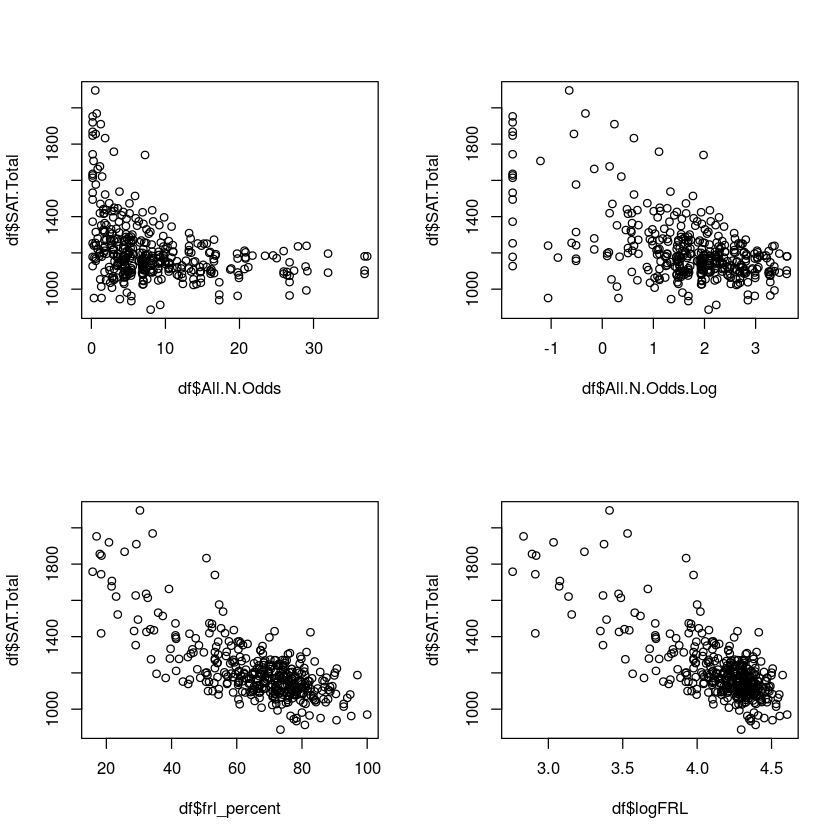

In [113]:
df[df$All.N.Odds==0,]$All.N.Odds = min(df[df$All.N.Odds>0,]$All.N.Odds)
df$All.N.Odds.Log <- log(df$All.N.Odds)
df$logFRL <- log(df$frl_percent)

par(mfrow=c(2,2))
plot(df$All.N.Odds, df$SAT.Total, )
plot(df$All.N.Odds.Log, df$SAT.Total)
plot(df$frl_percent, df$SAT.Total, )
plot(df$logFRL, df$SAT.Total)

In [114]:
table$All.N.Odds.Log <- df$All.N.Odds.Log
table$logFRL <- df$logFRL

fin.table <- cor(table)[5:13,1:4]
colnames(fin.table)[colnames(fin.table)=="SAT.Critical.Reading.Avg..Score"] = "Critical.Reading"
colnames(fin.table)[colnames(fin.table)=="SAT.Math.Avg..Score"] = "Math"
colnames(fin.table)[colnames(fin.table)=="SAT.Writing.Avg..Score"] = "Writing"
fin.table

,SAT.Total,Critical.Reading,Math,Writing
frl_percent,-0.7308846,-0.7428857,-0.6594218,-0.7356473
white_per,0.6432816,0.6164453,0.6149551,0.6454338
hispanic_per,-0.3729197,-0.3742063,-0.3631016,-0.3505663
black_per,-0.3041188,-0.2216271,-0.3824587,-0.2712448
asian_per,0.5518207,0.4329620,0.7004518,0.4551767
Average.Class.Size,0.3929568,0.3703276,0.3773611,0.3984169
All.N.Odds,-0.3588764,-0.3396145,-0.3664046,-0.3384291
All.N.Odds.Log,-0.5424194,-0.5182267,-0.5381338,-0.5240743
logFRL,-0.7667505,-0.7709815,-0.6968271,-0.7742553


We can observe a notably higher correlations using these transformations.

# Regression

The goal of this analysis is two-fold. The first is to create the strongest possible model for predicting SAT scores. The second goal is to compare the strength of all the different predictors: between income, crime levels, class size, and demographics, which have the stongest association with test scores? Furthermore, since previous research has established some ideas of which factors are associated with tests, we find specific interest in the collinearity between different predictors. For example, does racial composition have any association with test scores that cannot be explained by income or crime levels alone? 

To do this, we must first create our model using income. Then, we fill fit the other variables to see how our test statistics change.

In [115]:
fit <- lm(SAT.Total~ logFRL, data=df)
summary(fit)


Call:
lm(formula = SAT.Total ~ logFRL, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-332.99  -68.44   -5.92   59.56  560.79 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3010.92      78.40   38.41   <2e-16 ***
logFRL       -432.61      18.83  -22.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 115.1 on 370 degrees of freedom
Multiple R-squared:  0.5879,	Adjusted R-squared:  0.5868 
F-statistic: 527.9 on 1 and 370 DF,  p-value: < 2.2e-16


Once income is fit to our model, we can then proceed using a forward selection process by looking at which remaining variables have the strongest correlation with the residuals of the previous model, and fitting the variable if the regression coefficient was statistically significant (p > 0.05) and there was an improvedment in adjusted R^2. First we will do a couple more possible transformations, then check our residual correlations:

In [116]:
df$res <- resid(fit)
df$sqrtAP <- sqrt(df$asian_per)
df$sqrtWP <- sqrt(df$white_per)
df$sqrtBP <- sqrt(df$black_per)

cor(df[3:length(df)])[28,]

Num.of.SAT.Test.Takers SAT.Critical.Reading.Avg..Score 
                   2.895369e-01                    6.028256e-01 
            SAT.Math.Avg..Score          SAT.Writing.Avg..Score 
                   6.587394e-01                    6.062032e-01 
                      SAT.Total                     frl_percent 
                   6.419452e-01                    2.433878e-02 
               total_enrollment                         grade12 
                   1.927164e-01                    2.042808e-01 
                      asian_per                       black_per 
                   4.319459e-01                   -3.054769e-01 
                   hispanic_per                       white_per 
                   1.503617e-02                    8.164843e-02 
                       male_per               Percent.SAT.Taken 
                  -5.640815e-02                    8.436965e-02 
             Average.Class.Size                         Major.N 
                   1.699391e-01                   -1.095601e-01 
                       NoCrim.N                          Prop.N 
                  -1.532592e-01                   -1.122116e-01 
                          Vio.N                           All.N 
                  -1.604359e-01                   -1.651160e-01 
                   Major.N.Odds                   NoCrim.N.Odds 
                  -9.809356e-02                   -1.760869e-01 
                    Prop.N.Odds                      Vio.N.Odds 
                  -9.849260e-02                   -1.224932e-01 
                     All.N.Odds                  All.N.Odds.Log 
                  -1.557422e-01                   -2.713209e-01 
                         logFRL                             res 
                   1.557641e-18                    1.000000e+00 
                         sqrtAP                          sqrtWP 
                   4.075645e-01                    1.730573e-01 
                         sqrtBP 
                  -2.767818e-01

The next best variable appers to be asian_per, which we can fit:

In [118]:
fit <- lm(SAT.Total ~ frl_percent + asian_per, data=df)
summary(fit)


Call:
lm(formula = SAT.Total ~ frl_percent + asian_per, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-288.12  -62.81   -0.71   61.75  394.30 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1624.8479    27.0986  59.961   <2e-16 ***
frl_percent   -6.7833     0.3750 -18.090   <2e-16 ***
asian_per      3.9166     0.3971   9.864   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 109 on 369 degrees of freedom
Multiple R-squared:  0.6314,	Adjusted R-squared:  0.6294 
F-statistic:   316 on 2 and 369 DF,  p-value: < 2.2e-16


We can observe an improvement in adjusted R-squared here (from 0.5868 to 0.6294) indicating that the ratio of the proportion of variation in a school's SAT scores that can be explained by the school's composition of students that identify as Asian still exists after considering income. This already may suggest some bias in the way schools are distributed across different racial barriers, or differences in challenges that race may present in test scores.

We will continue the forward selection process:

In [119]:
df$res <- resid(fit)
cor(df[3:length(df)])[28,]

Num.of.SAT.Test.Takers SAT.Critical.Reading.Avg..Score 
                   1.146260e-01                    6.243422e-01 
            SAT.Math.Avg..Score          SAT.Writing.Avg..Score 
                   5.269205e-01                    6.271342e-01 
                      SAT.Total                     frl_percent 
                   6.071314e-01                    1.735253e-18 
               total_enrollment                         grade12 
                   2.979775e-02                    3.650596e-02 
                      asian_per                       black_per 
                  -1.162811e-18                   -2.003641e-01 
                   hispanic_per                       white_per 
                   1.228092e-01                    1.581391e-01 
                       male_per               Percent.SAT.Taken 
                  -1.195017e-01                    2.440701e-04 
             Average.Class.Size                         Major.N 
                   1.536142e-01                   -8.047103e-02 
                       NoCrim.N                          Prop.N 
                  -9.775170e-02                   -1.140232e-01 
                          Vio.N                           All.N 
                  -1.125898e-01                   -1.138989e-01 
                   Major.N.Odds                   NoCrim.N.Odds 
                  -5.342546e-02                   -9.611875e-02 
                    Prop.N.Odds                      Vio.N.Odds 
                  -6.820417e-02                   -5.879158e-02 
                     All.N.Odds                  All.N.Odds.Log 
                  -8.549029e-02                   -2.488242e-01 
                         logFRL                             res 
                  -8.481007e-02                    1.000000e+00 
                         sqrtAP                          sqrtWP 
                   1.090362e-02                    1.619773e-01 
                         sqrtBP 
                  -1.678013e-01

In [120]:
fit <- lm(SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log, data=df)
summary(fit)


Call:
lm(formula = SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-274.23  -62.99    1.65   60.65  383.61 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1629.1711    26.0130  62.629  < 2e-16 ***
frl_percent      -5.9777     0.3863 -15.473  < 2e-16 ***
asian_per         3.3852     0.3921   8.633  < 2e-16 ***
All.N.Odds.Log  -31.3718     5.4796  -5.725 2.15e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 104.6 on 368 degrees of freedom
Multiple R-squared:  0.6615,	Adjusted R-squared:  0.6588 
F-statistic: 239.8 on 3 and 368 DF,  p-value: < 2.2e-16


The next most significant variable appears to be the crime, which also shows a jump in our test statistics. We will continue fitting variables using this process.

In [121]:
df$res <- resid(fit)
cor(df[3:length(df)])[28,]

Num.of.SAT.Test.Takers SAT.Critical.Reading.Avg..Score 
                   1.429984e-01                    6.002835e-01 
            SAT.Math.Avg..Score          SAT.Writing.Avg..Score 
                   5.021772e-01                    6.020159e-01 
                      SAT.Total                     frl_percent 
                   5.817744e-01                    8.339750e-18 
               total_enrollment                         grade12 
                   6.191857e-02                    6.658257e-02 
                      asian_per                       black_per 
                   1.649936e-17                   -1.132446e-01 
                   hispanic_per                       white_per 
                   5.118277e-02                    1.205628e-01 
                       male_per               Percent.SAT.Taken 
                  -9.716485e-02                    9.505204e-03 
             Average.Class.Size                         Major.N 
                   1.582431e-01                    3.698147e-02 
                       NoCrim.N                          Prop.N 
                  -3.020577e-02                   -8.508199e-03 
                          Vio.N                           All.N 
                  -1.077424e-02                   -2.336403e-02 
                   Major.N.Odds                   NoCrim.N.Odds 
                   1.196995e-01                    6.544457e-02 
                    Prop.N.Odds                      Vio.N.Odds 
                   9.948905e-02                    1.051607e-01 
                     All.N.Odds                  All.N.Odds.Log 
                   1.217276e-01                   -6.889920e-19 
                         logFRL                             res 
                  -7.324558e-02                    1.000000e+00 
                         sqrtAP                          sqrtWP 
                   2.531195e-03                    1.204882e-01 
                         sqrtBP 
                  -7.320230e-02

In [122]:
fit <- lm(SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log + black_per, data=df)
summary(fit)


Call:
lm(formula = SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log + 
    black_per, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-267.31  -57.12    0.22   61.02  390.25 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1665.6784    29.3243  56.802  < 2e-16 ***
frl_percent      -6.2314     0.3953 -15.763  < 2e-16 ***
asian_per         2.9531     0.4225   6.990 1.31e-11 ***
All.N.Odds.Log  -25.8901     5.8245  -4.445 1.17e-05 ***
black_per        -0.6380     0.2433  -2.622  0.00911 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 103.7 on 367 degrees of freedom
Multiple R-squared:  0.6678,	Adjusted R-squared:  0.6641 
F-statistic: 184.4 on 4 and 367 DF,  p-value: < 2.2e-16


In [123]:
df$res <- resid(fit)
cor(df[3:length(df)])[28,]

Num.of.SAT.Test.Takers SAT.Critical.Reading.Avg..Score 
                   1.245281e-01                    5.990703e-01 
            SAT.Math.Avg..Score          SAT.Writing.Avg..Score 
                   4.952936e-01                    5.947473e-01 
                      SAT.Total                     frl_percent 
                   5.764009e-01                    1.188336e-18 
               total_enrollment                         grade12 
                   3.979390e-02                    4.764253e-02 
                      asian_per                       black_per 
                  -5.558981e-18                   -1.083112e-17 
                   hispanic_per                       white_per 
                  -4.545046e-02                    7.539627e-02 
                       male_per               Percent.SAT.Taken 
                  -9.943632e-02                    1.200754e-02 
             Average.Class.Size                         Major.N 
                   1.541746e-01                    2.591884e-02 
                       NoCrim.N                          Prop.N 
                  -4.820702e-02                   -1.767057e-02 
                          Vio.N                           All.N 
                  -9.005850e-03                   -3.909148e-02 
                   Major.N.Odds                   NoCrim.N.Odds 
                   1.148303e-01                    6.036043e-02 
                    Prop.N.Odds                      Vio.N.Odds 
                   9.970357e-02                    1.145358e-01 
                     All.N.Odds                  All.N.Odds.Log 
                   1.215267e-01                    5.080606e-18 
                         logFRL                             res 
                  -6.411271e-02                    1.000000e+00 
                         sqrtAP                          sqrtWP 
                  -4.710031e-03                    7.732882e-02 
                         sqrtBP 
                   3.304031e-02

In [124]:
fit <- lm(SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log + black_per + Average.Class.Size, data=df)
summary(fit)


Call:
lm(formula = SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log + 
    black_per + Average.Class.Size, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-269.47  -61.79   -4.83   58.81  377.07 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1503.1634    57.8302  25.993  < 2e-16 ***
frl_percent          -5.8133     0.4110 -14.145  < 2e-16 ***
asian_per             2.8834     0.4177   6.904 2.25e-11 ***
All.N.Odds.Log      -26.0537     5.7505  -4.531 7.97e-06 ***
black_per            -0.6037     0.2405  -2.511  0.01248 *  
Average.Class.Size    5.6419     1.7380   3.246  0.00128 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 102.4 on 366 degrees of freedom
Multiple R-squared:  0.6771,	Adjusted R-squared:  0.6726 
F-statistic: 153.5 on 5 and 366 DF,  p-value: < 2.2e-16


In [125]:
fit <- lm(SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log + black_per + Average.Class.Size + All.N.Odds, data=df)
summary(fit)


Call:
lm(formula = SAT.Total ~ frl_percent + asian_per + All.N.Odds.Log + 
    black_per + Average.Class.Size + All.N.Odds, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-287.78  -60.34   -1.64   53.43  390.40 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1500.9213    56.6560  26.492  < 2e-16 ***
frl_percent          -5.7479     0.4029 -14.265  < 2e-16 ***
asian_per             2.9303     0.4093   7.159 4.51e-12 ***
All.N.Odds.Log      -51.5706     8.4572  -6.098 2.74e-09 ***
black_per            -0.5883     0.2356  -2.497   0.0130 *  
Average.Class.Size    5.6023     1.7026   3.290   0.0011 ** 
All.N.Odds            4.7949     1.1853   4.045 6.38e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 100.3 on 365 degrees of freedom
Multiple R-squared:  0.6909,	Adjusted R-squared:  0.6858 
F-statistic:   136 on 6 and 365 DF,  p-value: < 2.2e-16


In [126]:
df$res <- resid(fit)
cor(df[3:length(df)])[28,]

Num.of.SAT.Test.Takers SAT.Critical.Reading.Avg..Score 
                   1.250971e-01                    5.833520e-01 
            SAT.Math.Avg..Score          SAT.Writing.Avg..Score 
                   4.746945e-01                    5.716383e-01 
                      SAT.Total                     frl_percent 
                   5.559516e-01                    1.424674e-17 
               total_enrollment                         grade12 
                   4.769286e-02                    5.246331e-02 
                      asian_per                       black_per 
                   1.609741e-17                   -1.874869e-17 
                   hispanic_per                       white_per 
                  -4.045103e-02                    6.720921e-02 
                       male_per               Percent.SAT.Taken 
                  -7.863825e-02                    8.218019e-03 
             Average.Class.Size                         Major.N 
                  -4.348818e-17                   -8.592473e-03 
                       NoCrim.N                          Prop.N 
                  -5.553977e-02                   -1.631021e-02 
                          Vio.N                           All.N 
                  -3.164560e-02                   -5.019552e-02 
                   Major.N.Odds                   NoCrim.N.Odds 
                   4.839438e-03                   -3.733677e-02 
                    Prop.N.Odds                      Vio.N.Odds 
                   2.695057e-02                    1.254159e-02 
                     All.N.Odds                  All.N.Odds.Log 
                  -1.557800e-17                   -1.333575e-17 
                         logFRL                             res 
                  -5.581263e-02                    1.000000e+00 
                         sqrtAP                          sqrtWP 
                   2.470949e-03                    8.197076e-02 
                         sqrtBP 
                   3.831051e-02

In [127]:
fit <- lm(SAT.Total ~ log(frl_percent) + asian_per + All.N.Odds.Log + Average.Class.Size + black_per + All.N.Odds, data=df)
summary(fit)


Call:
lm(formula = SAT.Total ~ log(frl_percent) + asian_per + All.N.Odds.Log + 
    Average.Class.Size + black_per + All.N.Odds, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-271.43  -53.23   -3.33   52.19  404.66 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2391.6162   100.3987  23.821  < 2e-16 ***
log(frl_percent)   -310.2909    19.7836 -15.684  < 2e-16 ***
asian_per             3.0967     0.3905   7.929 2.71e-14 ***
All.N.Odds.Log      -41.9917     8.3099  -5.053 6.88e-07 ***
Average.Class.Size    5.5230     1.6349   3.378 0.000808 ***
black_per            -0.2938     0.2229  -1.318 0.188245    
All.N.Odds            3.5892     1.1487   3.124 0.001924 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 96.78 on 365 degrees of freedom
Multiple R-squared:  0.7124,	Adjusted R-squared:  0.7077 
F-statistic: 150.7 on 6 and 365 DF,  p-value: < 2.2e-16


All of the statistically significant variables have been fit. It suggests that crime, race, and class size all play roles in SAT scores that can't be explained by income alone. We can also use an F-test to compare a constrained model with an unconstrained model. 

In [128]:
library(MASS)

Here are a couple examples:

In [129]:
fit1 <- lm(SAT.Total~log(frl_percent), data=df)  #constrained model
fit2 <- lm(SAT.Total~as.factor(log(frl_percent)), data=df)  #unconstrained model
anova(fit1, fit2)

fit1 <- lm(SAT.Total~(frl_percent), data=df)  #constrained model
fit2 <- lm(SAT.Total~as.factor((frl_percent)), data=df)  #unconstrained model
anova(fit1, fit2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
370,4898578.5,NA,NA,NA,NA
112,969680.9,258,3928898,1.758896,0.0003904836


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
370,5537079.4,NA,NA,NA,NA
112,969680.9,258,4567399,2.044741,1.283474e-05


More examples:

In [130]:
fit <- lm(SAT.Total ~ log(frl_percent) + All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
fit2 <- lm(SAT.Total ~ log(frl_percent) +  All.N.Odds.Log + Average.Class.Size + All.N.Odds, data=df)
anova(fit1, fit2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
370,5537079,NA,NA,NA,NA
367,4199208,3,1337871,38.9755,6.911559e-22


In [131]:
full <- lm(SAT.Critical.Reading.Avg..Score ~ log(frl_percent) + All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
reduced <- lm(SAT.Critical.Reading.Avg..Score ~ log(frl_percent) +  All.N.Odds.Log + Average.Class.Size + All.N.Odds, data=df)
anova(full, reduced)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
364,432018.7,NA,NA,NA,NA
367,453042.6,-3,-21023.92,5.904611,0.0006073363


In [132]:
full.M <- lm(SAT.Math.Avg..Score ~ log(frl_percent) + All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
reduced.M <- lm(SAT.Math.Avg..Score ~ log(frl_percent) +  All.N.Odds.Log + Average.Class.Size + All.N.Odds, data=df)
anova(full.M, reduced.M)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
364,400902.3,NA,NA,NA,NA
367,716966.4,-3,-316064.1,95.657,1.14618e-45


In [133]:
full.W <- lm(SAT.Writing.Avg..Score ~ log(frl_percent) + All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
reduced.W <- lm(SAT.Writing.Avg..Score ~ log(frl_percent) +  All.N.Odds.Log + Average.Class.Size + All.N.Odds, data=df)
anova(full.W, reduced.W)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
364,431378.9,NA,NA,NA,NA
367,464674.5,-3,-33295.64,9.365016,5.608668e-06


In [134]:
full <- lm(SAT.Total ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per + log(frl_percent), data=df)
reduced <- lm(SAT.Total ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
anova(full, reduced)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
364,3416363,NA,NA,NA,NA
365,4399078,-1,-982714.7,104.7044,9.106668e-22


In [135]:
full <- lm(SAT.Critical.Reading.Avg..Score ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per + log(frl_percent), data=df)
reduced <- lm(SAT.Critical.Reading.Avg..Score ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
anova(full, reduced)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
364,432018.7,NA,NA,NA,NA
365,569263.5,-1,-137244.7,115.6364,1.320641e-23


In [136]:
full.M <- lm(SAT.Math.Avg..Score ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per + log(frl_percent), data=df)
reduced.M <- lm(SAT.Math.Avg..Score ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
anova(full.M, reduced.M)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
364,400902.3,NA,NA,NA,NA
365,468618.9,-1,-67716.56,61.48337,4.991261e-14


In [137]:
full <- lm(SAT.Writing.Avg..Score ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per + log(frl_percent), data=df)
reduced <- lm(SAT.Writing.Avg..Score ~ All.N.Odds.Log + Average.Class.Size + All.N.Odds + black_per + asian_per + white_per, data=df)
anova(full, reduced)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
364,431378.9,NA,NA,NA,NA
365,561432.9,-1,-130054,109.7403,1.279188e-22
